In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk 
import sqlalchemy
import seaborn as sns
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.base import TransformerMixin
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor, RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import train_test_split, cross_val_score, KFold
import xgboost as xgb
from sklearn import metrics

%matplotlib inline

In [2]:
def convertNA(value):
    try:
        if np.isnan(value):
            return "None"
        else:
            return value
    except:
        return value

In [3]:
train  = pd.read_csv("../assets/train.csv")
test = pd.read_csv("../assets/test.csv")

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

categories = [u"Alley","Fence","PoolQC","GarageCond","GarageQual","GarageFinish","MiscFeature","GarageType","FireplaceQu","BsmtFinType2","BsmtFinType1","BsmtCond","BsmtQual"]
for column in categories:
    all_data[column] = all_data[column].apply(convertNA)

all_data.fillna(all_data.mean(),inplace=True)

all_data = pd.get_dummies(all_data)

X = all_data.iloc[:1460,:]
X_test = all_data.iloc[1460:,:]
y = train["SalePrice"]

In [4]:
train["Id"].count()

1460

In [5]:
cv = KFold(len(y),shuffle=False)

dt = DecisionTreeRegressor(random_state=5)
dtScore = cross_val_score(dt,X,y, cv=cv, n_jobs=-1)
dtScore

array([ 0.76034888,  0.74085025,  0.53245329])

In [6]:
rf = RandomForestRegressor(random_state=5)
rfScore = cross_val_score(rf,X,y,cv=cv, n_jobs=-1)
model = rf.fit(X,y)
predictions = model.predict(X)
rfScore

array([ 0.86873218,  0.82449725,  0.80051806])

In [7]:
ab = AdaBoostRegressor(random_state=5)
abScore = cross_val_score(ab,X,y,cv=cv,n_jobs=-1)
abScore

array([ 0.84804748,  0.8037326 ,  0.72073568])

In [8]:
gb = GradientBoostingRegressor(random_state=5)
gbScore = cross_val_score(ab,X,y,cv=cv,n_jobs=-1)
gbScore

array([ 0.84804748,  0.8037326 ,  0.72073568])

In [9]:
print "Decision Tree Score: %f" % dtScore.mean()
print "Random Forest Score: %f" % rfScore.mean()
print "AdaBoost Score: %f" % abScore.mean()
print "Gradient Boost Score: %f" % gbScore.mean()

Decision Tree Score: 0.677884
Random Forest Score: 0.831249
AdaBoost Score: 0.790839
Gradient Boost Score: 0.790839


In [10]:
model = rf.fit(X,y)
predictions = model.predict(X_test)

In [11]:
submission = pd.DataFrame()
submission["Id"] = test["Id"]
submission["SalePrice"] = predictions
submission.to_csv("../assets/submission.csv", index=False)

In [12]:
def rmsle(y_predict,y_actual):
    return np.sqrt(np.mean(np.power(np.log1p(y_predict) - np.log1p(y_actual), 2)))

In [1]:
def modelfit(alg, X, X_test, y, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):

    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X.values, label=y.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X, y,eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    dtest_predictions = alg.predict(X_test)
    
    #dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    #Print model report:
    print "\nModel Report"
    #print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['SalePrice'].values.astype(float), dtrain_predictions.astype(float))
    #print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['SalePrice'], dtrain_predprob)
    print "Score: ", metrics.r2_score(y,dtrain_predictions)
    print "RMSLE: ", rmsle(y,dtrain_predictions)
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
    return dtest_predictions
    
#     submission = pd.DataFrame()
#     submission["Id"] = dtest["Id"].values.astype(int)
#     submission["SalePrice"] = dtest_predictions
#     submission.to_csv("../assets/submission.csv", index=False)


Model Report
Score:  0.996843761623
RMSLE:  0.0306278568394


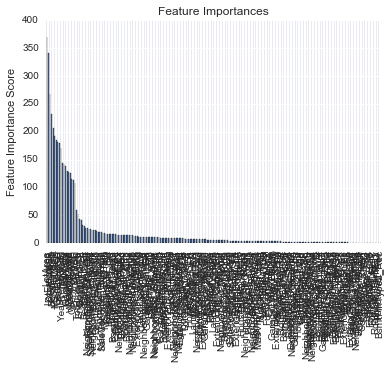

In [14]:
xgb1 = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
model = modelfit(xgb1, X, X_test, y)

In [15]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor(learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='r2',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X,y)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.88126, std: 0.02771, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.88462, std: 0.02637, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.87737, std: 0.03219, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.87786, std: 0.01931, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.88619, std: 0.02339, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.88230, std: 0.03135, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.87268, std: 0.02102, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.88252, std: 0.02684, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.87710, std: 0.03333, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.87131, std: 0.02223, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.88085, std: 0.02752, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.87536, std: 0.03672, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_child_weight': 3

In [16]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[2,3,4]
}
gsearch2 = GridSearchCV(estimator = xgb.XGBRegressor(learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring='r2',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X,y)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.88188, std: 0.02176, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: 0.88612, std: 0.02580, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: 0.88383, std: 0.02971, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: 0.88508, std: 0.02392, params: {'max_depth': 5, 'min_child_weight': 2},
  mean: 0.88619, std: 0.02339, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.88209, std: 0.03190, params: {'max_depth': 5, 'min_child_weight': 4},
  mean: 0.88418, std: 0.01538, params: {'max_depth': 6, 'min_child_weight': 2},
  mean: 0.88703, std: 0.01996, params: {'max_depth': 6, 'min_child_weight': 3},
  mean: 0.88394, std: 0.03239, params: {'max_depth': 6, 'min_child_weight': 4}],
 {'max_depth': 6, 'min_child_weight': 3},
 0.88702673882035799)

In [17]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = xgb.XGBRegressor(learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test3, scoring='r2',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X,y)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.87786, std: 0.01931, params: {'gamma': 0.0},
  mean: 0.87786, std: 0.01931, params: {'gamma': 0.1},
  mean: 0.87786, std: 0.01931, params: {'gamma': 0.2},
  mean: 0.87786, std: 0.01931, params: {'gamma': 0.3},
  mean: 0.87786, std: 0.01931, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 0.87786464426588107)

In [18]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = xgb.XGBRegressor(learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test4, scoring='r2',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X,y)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.88433, std: 0.03289, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: 0.89779, std: 0.02131, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: 0.88497, std: 0.02516, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: 0.88375, std: 0.02886, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: 0.88050, std: 0.02848, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: 0.89064, std: 0.02246, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: 0.88234, std: 0.02537, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: 0.87829, std: 0.02584, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: 0.88240, std: 0.03132, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: 0.89315, std: 0.01689, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: 0.87786, std: 0.01931, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: 0.87664, std: 0.01777, params: {'subsample': 0.9, 'colsample_bytree'

In [19]:
param_test5 = {
 'subsample':[i/100.0 for i in range(55,70,5)],
 'colsample_bytree':[i/100.0 for i in range(65,80,5)]
}
gsearch5 = GridSearchCV(estimator = xgb.XGBRegressor(learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test5, scoring='r2',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X,y)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.88244, std: 0.03239, params: {'subsample': 0.55, 'colsample_bytree': 0.65},
  mean: 0.88183, std: 0.02929, params: {'subsample': 0.6, 'colsample_bytree': 0.65},
  mean: 0.88901, std: 0.02276, params: {'subsample': 0.65, 'colsample_bytree': 0.65},
  mean: 0.88054, std: 0.03662, params: {'subsample': 0.55, 'colsample_bytree': 0.7},
  mean: 0.88050, std: 0.02848, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: 0.88602, std: 0.02303, params: {'subsample': 0.65, 'colsample_bytree': 0.7},
  mean: 0.88094, std: 0.03521, params: {'subsample': 0.55, 'colsample_bytree': 0.75},
  mean: 0.87686, std: 0.03068, params: {'subsample': 0.6, 'colsample_bytree': 0.75},
  mean: 0.88498, std: 0.02816, params: {'subsample': 0.65, 'colsample_bytree': 0.75}],
 {'colsample_bytree': 0.65, 'subsample': 0.65},
 0.88901197205857196)

In [20]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = xgb.XGBRegressor(learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test6, scoring='r2',n_jobs=4,iid=False, cv=5)
gsearch6.fit(X,y)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.87786, std: 0.01931, params: {'reg_alpha': 1e-05},
  mean: 0.87786, std: 0.01931, params: {'reg_alpha': 0.01},
  mean: 0.87786, std: 0.01931, params: {'reg_alpha': 0.1},
  mean: 0.87786, std: 0.01931, params: {'reg_alpha': 1},
  mean: 0.87696, std: 0.01873, params: {'reg_alpha': 100}],
 {'reg_alpha': 1e-05},
 0.87786464386046092)

In [21]:
param_test7 = {
 'reg_alpha':[.1e-5, .5e-5, 1e-5, 5e-5, 1e-4]
}
gsearch7 = GridSearchCV(estimator = xgb.XGBRegressor(learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test6, scoring='r2',n_jobs=4,iid=False, cv=5)
gsearch7.fit(X,y)
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

([mean: 0.87786, std: 0.01931, params: {'reg_alpha': 1e-05},
  mean: 0.87786, std: 0.01931, params: {'reg_alpha': 0.01},
  mean: 0.87786, std: 0.01931, params: {'reg_alpha': 0.1},
  mean: 0.87786, std: 0.01931, params: {'reg_alpha': 1},
  mean: 0.87696, std: 0.01873, params: {'reg_alpha': 100}],
 {'reg_alpha': 1e-05},
 0.87786464386046092)


Model Report
Score:  0.989282774789
RMSLE:  0.054747502746


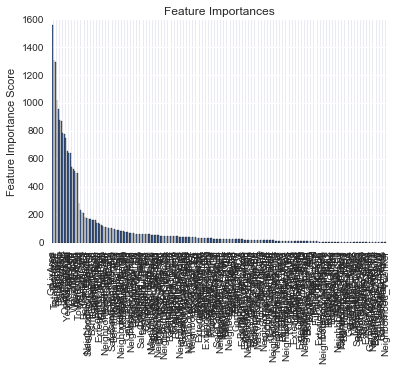

In [22]:
xgb1 = xgb.XGBRegressor(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=6,
 min_child_weight=3,
 gamma=0,
 subsample=0.65,
 colsample_bytree=0.65,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 reg_alpha= 1e-05,
 seed=27)
model = modelfit(xgb1, X, X_test, y)

In [23]:
predictions = xgb1.predict(X_test)

In [24]:
submission = pd.DataFrame()
submission["Id"] = test["Id"]
submission["SalePrice"] = predictions
submission.to_csv("../assets/submission.csv", index=False)

In [26]:
feat_imp = pd.Series(xgb1.booster().get_fscore()).sort_values(ascending=False)

In [37]:
selected_features = feat_imp[feat_imp/sum(feat_imp) > .001].index.values

In [38]:
X_selected = X[selected_features]
X_selected_test = X_test[selected_features]


Model Report
Score:  0.98849056947
RMSLE:  0.056686216709


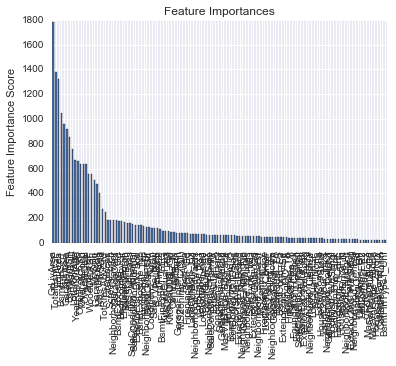

In [39]:
xgb1 = xgb.XGBRegressor(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=6,
 min_child_weight=3,
 gamma=0,
 subsample=0.65,
 colsample_bytree=0.65,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 reg_alpha= 1e-05,
 seed=27)
model = modelfit(xgb1, X_selected, X_selected_test, y)

In [43]:
predictions = xgb1.predict(X_selected_test)

In [44]:
submission = pd.DataFrame()
submission["Id"] = test["Id"]
submission["SalePrice"] = predictions
submission.to_csv("../assets/submission.csv", index=False)